# Loading HDF5 data
**Loading ptychographic X-ray data into PtyPy from an HDF5 file, running a phase retrieval engine and inspecting the output.**

PtyPy uses the [PtyScan](https://ptycho.github.io/ptypy/rst/ptypy.core.html#ptypy.core.data.PtyScan) class to interact with experimental data and traditionally it was recommended that users write their own PtyScan subclass for each experiment or beamline, as documented in this tutorial on [Data Management](https://ptycho.github.io/ptypy/rst/data_management.html). This approach is extremely flexible since it allows users full control on defining how their data should be loaded based on whatever file format their data is stored with, but it requires some programming efforts and can therefore be a barrier for new ptychography users. However, if your exprimental data is stored in an HDF5 file - a file format adopted by most instruments and facilities - it is much simpler to just use the [Hdf5Loader](https://ptycho.github.io/ptypy/rst/ptypy.experiment.html#ptypy.experiment.hdf5_loader.Hdf5Loader) PtyScan subclass which already provides a generic interface to load ptychographic data of a single or multiple HDF5 files into Ptypy. 

## The data

In this example, we use an experimental data set collected at the I08-1 instrument at the Diamond Light Source on a test sample (gold nanostructures deposited on a carbon film). A subset of the experimental data including some meta information has been saved in an HDF5 file named "dls_i08_nanogold_small.h5" that was specifically created for the purpose of this tutorial. We can use the following code
```python
import h5py, os
tutorial_data_home = "../../data/"
dataset = "small_data/dls_i08_nanogold_small.h5"
path_to_data = os.path.join(tutorial_data_home, dataset)
with h5py.File(path_to_data) as f:
    print("The file {} has the following entries: \n".format(path_to_data))
    print('\n'.join('\t* {0:<13} \tshape = {1:}'.format(k,f[k].shape) for k in list(f)))
```
to list all entires/keys saved at the root level
```
The file /global/homes/b/benedikt/workshop_data/small_data/dls_i08_nanogold_small.h5 has the following entries: 

	|- data          	shape = (707, 128, 128)
	|- det_distance_mm 	shape = ()
	|- det_pixelsize_um 	shape = ()
	|- energy_ev     	shape = ()
	|- posx_mm       	shape = (707,)
	|- posy_mm       	shape = (707,)
```

---

In [ ]:
import h5py, os
tutorial_data_home = "../../data/"
dataset = "small_data/dls_i08_nanogold_small.h5"
path_to_data = os.path.join(tutorial_data_home, dataset)
with h5py.File(path_to_data) as f:
    print("The file {} has the following entries: \n".format(path_to_data))
    print('\n'.join('\t* {0:<13} \tshape = {1:}'.format(k,f[k].shape) for k in list(f)))


## Loading the data
This example helps us getting started with using the Hdf5Loader, which is going to be used throughout the rest of the tutorials. First, we need to make sure that the `hdf5_loader` module is loaded
```python
ptypy.load_ptyscan_module("hdf5_loader")
```

which enables us to use `'Hdf5Loader'` as our data loading class

```python
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'Hdf5Loader'
```


Now, the only thing left to do is pointing the different data parameters to the relevant files and keys. For the diffraction intensities, we specify
```python
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data"
```

For the scan positions we separately read ```posy_mm``` as the slow and ```posx_mmm``` as the fast axis, and we also need to provide the correct multiplier that converts to SI units (meters)
```python
p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = path_to_data
p.scans.scan_00.data.positions.slow_key = "posy_mm"
p.scans.scan_00.data.positions.slow_multiplier = 1e-3
p.scans.scan_00.data.positions.fast_key = "posx_mm"
p.scans.scan_00.data.positions.fast_multiplier = 1e-3
```

For the photon energy, we use the ```energy_ev``` key and convert to units of keV
```python
p.scans.scan_00.data.recorded_energy = u.Param()
p.scans.scan_00.data.recorded_energy.file = path_to_data
p.scans.scan_00.data.recorded_energy.key = "energy_ev"
p.scans.scan_00.data.recorded_energy.multiplier = 1e-3
```

For the detector distance, we use the ```det_distance_mm``` key and convert to SI units
```python
p.scans.scan_00.data.recorded_distance = u.Param()
p.scans.scan_00.data.recorded_distance.file = path_to_data
p.scans.scan_00.data.recorded_distance.key = "det_distance_mm"
p.scans.scan_00.data.recorded_distance.multiplier = 1e-3
```

And finally, for the detector pixel size, we use the ```det_pixelsize_um``` and conver to SI units#
```python
p.scans.scan_00.data.recorded_psize = u.Param()
p.scans.scan_00.data.recorded_psize.file = path_to_data
p.scans.scan_00.data.recorded_psize.key = "det_pixelsize_um"
p.scans.scan_00.data.recorded_psize.multiplier = 1e-6
```

`````{admonition} Note 
:class: note
Instead of reading energy, distance or pixel size from the file we can also provide them directly by setting <code>p.scans.scan_00.data.energy</code>, <code>p.scans.scan_00.data.distance</code> or <code>p.scans.scan_00.data.psize</code> in SI units. 
`````

## Initial probe

When working with experimental data, choosing a good starting guess for the illumination (probe) can be very important. For this example based on data collected at the I08-1 instrument at the Diamond Light Source, we use the following settings to model the I08-1 Fresnel Zone Plate (FZP) 
```python
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.model = None
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = "circ"
p.scans.scan_00.illumination.aperture.size = 333e-6
p.scans.scan_00.illumination.propagation = u.Param()
p.scans.scan_00.illumination.propagation.focussed = 13.725e-3
p.scans.scan_00.illumination.propagation.parallel = 45e-6
```
which has a circular aperture of $333 \,\mathrm{ \mu m}$ in diameter and a focal length of $13.725\,\mathrm{mm}$. We also estimate the sample plane to be $45\,\mathrm{\mu m}$ downstream of the focus.

## Reconstruction engine
For many X-ray data sets, difference map (DM) can be a good starting point for simultaneous object and probe retrieval because of the explorative nature of the algorithm. Here, we use DM with $\alpha=0.9$

```python
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "DM_cupy"
p.engines.engine.numiter = 200
p.engines.engine.numiter_contiguous = 10
p.engines.engine.alpha = 0.9
p.engines.engine.probe_support = None
p.engines.engine.probe_update_start = 0
```

resulting in the following reconstruction after 200 iterations of DM showing a section of the nanogold sample

![](./_assets/i08_recons_dm.png)

`````{admonition} Exercise 
:class: attention
Modify the optical parameters used for estimating the initial probe and observe if/how it improves the quality or convergence of the reconstruction.
`````

---

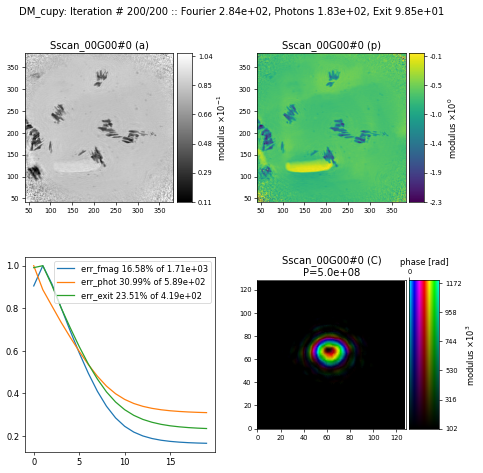


==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The difference map reconstruction algorithm:
    Thibault et al., "Probe retrieval in ptychographic coherent diffractive imaging" Ultramicroscopy 109 (2009) 338, doi: 10.1016/j.ultramic.2008.12.011.


<Figure size 640x480 with 0 Axes>

In [4]:
import ptypy, os
import ptypy.utils as u

# This will import the HDF5Loader class
ptypy.load_ptyscan_module("hdf5_loader")

# This will import the GPU engines
ptypy.load_gpu_engines("cupy")

# Root directory of tutorial data
tutorial_data_home = "../../data/"

# Dataset for this tutorial
dataset = "small_data/dls_i08_nanogold_small.h5"

# Absolute path to HDF5 file with raw data
path_to_data = os.path.join(tutorial_data_home, dataset)

# Create parameter tree
p = u.Param()

# Set verbose level to interactive
p.verbose_level = "interactive"

# Set io settings (no files saved)
p.io = u.Param()
p.io.rfile = None
p.io.autosave = u.Param(active=False)
p.io.interaction = u.Param(active=False)

# Live-plotting during the reconstruction
p.io.autoplot = u.Param()
p.io.autoplot.active=True
p.io.autoplot.threaded = False
p.io.autoplot.layout = "jupyter"
p.io.autoplot.interval = 10

# Define the scan model
p.scans = u.Param()
p.scans.scan_00 = u.Param()
p.scans.scan_00.name = 'Full'

# Initial illumination (based on simulated optics)
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.model = None
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = "circ"
p.scans.scan_00.illumination.aperture.size = 333e-6
p.scans.scan_00.illumination.propagation = u.Param()
p.scans.scan_00.illumination.propagation.focussed = 13.725e-3
p.scans.scan_00.illumination.propagation.parallel = 45e-6

# Data loader
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'Hdf5Loader'

# Read diffraction data
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data"

# Read positions data
p.scans.scan_00.data.positions = u.Param()
p.scans.scan_00.data.positions.file = path_to_data
p.scans.scan_00.data.positions.slow_key = "posy_mm"
p.scans.scan_00.data.positions.slow_multiplier = 1e-3
p.scans.scan_00.data.positions.fast_key = "posx_mm"
p.scans.scan_00.data.positions.fast_multiplier = 1e-3

# Read meta data: photon energy
p.scans.scan_00.data.recorded_energy = u.Param()
p.scans.scan_00.data.recorded_energy.file = path_to_data
p.scans.scan_00.data.recorded_energy.key = "energy_ev"
p.scans.scan_00.data.recorded_energy.multiplier = 1e-3

# Read meta data: detector distance
p.scans.scan_00.data.recorded_distance = u.Param()
p.scans.scan_00.data.recorded_distance.file = path_to_data
p.scans.scan_00.data.recorded_distance.key = "det_distance_mm"
p.scans.scan_00.data.recorded_distance.multiplier = 1e-3

# Read meta data: detector pixelsize
p.scans.scan_00.data.recorded_psize = u.Param()
p.scans.scan_00.data.recorded_psize.file = path_to_data
p.scans.scan_00.data.recorded_psize.key = "det_pixelsize_um"
p.scans.scan_00.data.recorded_psize.multiplier = 1e-6

# Define reconstruction engine (using DM)
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "DM_cupy"
p.engines.engine.numiter = 200
p.engines.engine.numiter_contiguous = 10
p.engines.engine.alpha = 0.9
p.engines.engine.probe_support = None
p.engines.engine.probe_update_start = 0

# Run reconstruction
P = ptypy.core.Ptycho(p,level=5)